In [1]:
import pandas as pd
dataset_name = "test"

dfans = pd.read_csv('output_'+dataset_name+'/GraderExperiment_'+dataset_name+'GTpanelindex.csv',index_col=0)
dfH = pd.read_csv('output_'+dataset_name+'/GraderExperiment_'+dataset_name+'_HK.csv',sep='\t',index_col='ScanID')
dfZ = pd.read_csv('output_'+dataset_name+'/GraderExperiment_'+dataset_name+'_ZW.csv',sep='\t',index_col='ScanID')
dfimg = pd.read_csv('output_'+dataset_name+'/dfimg_'+dataset_name+'.csv',index_col=0)

In [2]:
def grade(dfgrader):
    marks = (dfgrader['Prediction']==dfans['panel_index'])
    print('{} out of {} correct'.format(marks.sum(),len(marks)))
    dfgrades = pd.DataFrame(index = dfans.ImgId,data = marks.values, columns = ['gt_align'])
    align_w_dt = dfimg.loc[dfans[~marks]['ImgId']]
    align_w_gt = dfimg.loc[dfans[marks]['ImgId']]
    dfans[~marks].index
    rat = (align_w_dt.gt_instances<align_w_dt.dt_instances)
    print('Ratio of dt>gt in align_w_dt: {}:{}'.format(rat.sum(),(len(rat)-rat.sum())))
    rat = (align_w_gt.gt_instances<align_w_gt.dt_instances)
    print('Ratio of dt>gt in align_w_gt: {}:{}'.format(rat.sum(),(len(rat)-rat.sum())))
    return dfgrades


In [3]:
dfZW = grade(dfZ)
dfHK = grade(dfH)

20 out of 50 correct
Ratio of dt>gt in align_w_dt: 17:13
Ratio of dt>gt in align_w_gt: 8:12
18 out of 50 correct
Ratio of dt>gt in align_w_dt: 15:17
Ratio of dt>gt in align_w_gt: 10:8


Text(0.5, 0, 'ZW')

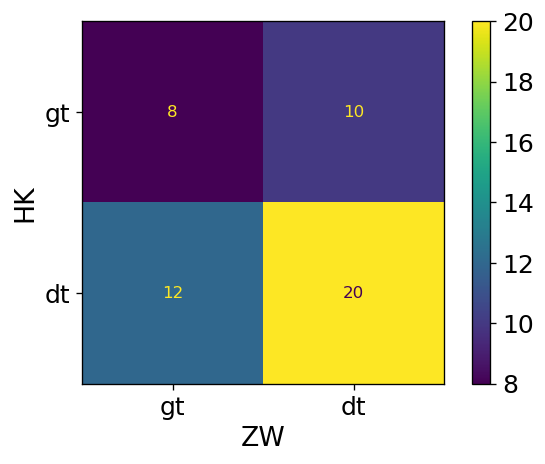

In [4]:
dfcm = dfZW.merge(dfHK,how='inner',on = 'ImgId',suffixes=['_ZW','_HK'])
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.style.use('ybpres.mplstyle')

cm = confusion_matrix(dfcm.gt_align_HK,dfcm.gt_align_ZW,labels = [True,False])
disp = ConfusionMatrixDisplay(cm,display_labels = ['gt','dt'] )
fig,ax = plt.subplots(dpi=120)
disp.plot(ax = ax)
ax.set_ylabel('HK')
ax.set_xlabel('ZW')

In [5]:
from confusion_matrix_pretty_print import insert_totals
import seaborn as sns

dfcm = pd.DataFrame(cm,columns= ['gt','dt'], index = ['gt','dt'])
insert_totals(dfcm)


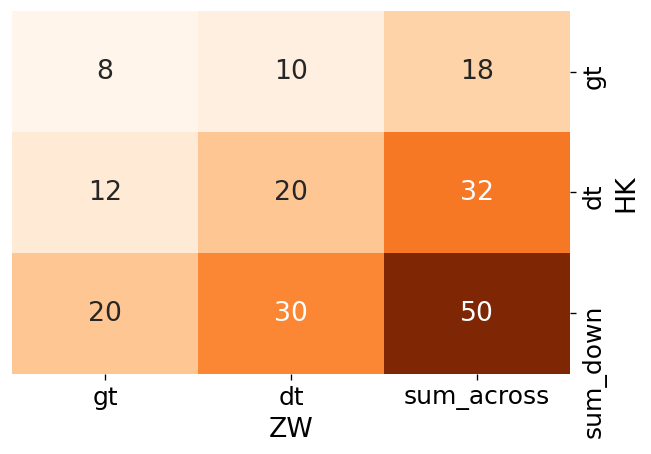

In [6]:
ax = sns.heatmap(dfcm,annot=True,cmap="Oranges",annot_kws={"size": 16},cbar=False)
ax.set_ylabel('HK')
ax.set_xlabel('ZW')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.gcf().dpi=120

In [4]:
dfZW.loc[set(dfHK.index).intersection(set(dfZW.index))]
dfimg.loc[set(dfHK.index)-set(dfZW.index)]
dfimg.loc[set(dfZW.index)-set(dfHK.index)]

,gt_instances,gt_pxs,gt_xpxs,dt_instances,dt_pxs,dt_xpxs,ptid,eye,scan
501010_OS_oct-002.png,1.0,136.0,20.0,0.0,0.0,0.0,501010,OS,oct-002
101334_OS_oct-035.png,1.0,121.0,17.0,4.0,621.0,104.0,101334,OS,oct-035
101334_OS_oct-040.png,3.0,469.0,66.0,2.0,336.0,59.0,101334,OS,oct-040
101344_OS_oct-040.png,0.0,0.0,0.0,1.0,178.0,35.0,101344,OS,oct-040
101334_OS_oct-021.png,2.0,254.0,27.0,3.0,425.0,62.0,101334,OS,oct-021
101334_OS_oct-027.png,0.0,0.0,0.0,1.0,425.0,68.0,101334,OS,oct-027
501010_OS_oct-034.png,5.0,791.0,103.0,2.0,404.0,45.0,501010,OS,oct-034
501010_OD_oct-037.png,1.0,107.0,13.0,0.0,0.0,0.0,501010,OD,oct-037
101334_OD_oct-027.png,0.0,0.0,0.0,2.0,299.0,55.0,101334,OD,oct-027
501010_OD_oct-012.png,3.0,517.0,65.0,2.0,273.0,33.0,501010,OD,oct-012


In [37]:
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset, OutputVis
import os

dataset_name = "test"
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

pred_file = "output_"+ dataset_name + "/coco_instances_results.json"
out_file_HK = os.path.join("output_"+ dataset_name,'GraderExperiment_'+dataset_name+'HK_align_w_dt.pdf')
out_file_ZW = os.path.join("output_"+ dataset_name,'GraderExperiment_'+dataset_name+'ZW_align_w_dt.pdf')

vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=True)

vis.output_to_pdf(ImgIds=dfHK.index.values,outname=out_file_HK,dfimg=dfHK)
vis.output_to_pdf(ImgIds=dfZW.index.values,outname=out_file_ZW,dfimg=dfZW)

  0%|          | 0/31 [00:00<?, ?it/s]

Already registered.


100%|██████████| 31/31 [00:50<00:00,  1.63s/it]
